<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "8E"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/8E/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


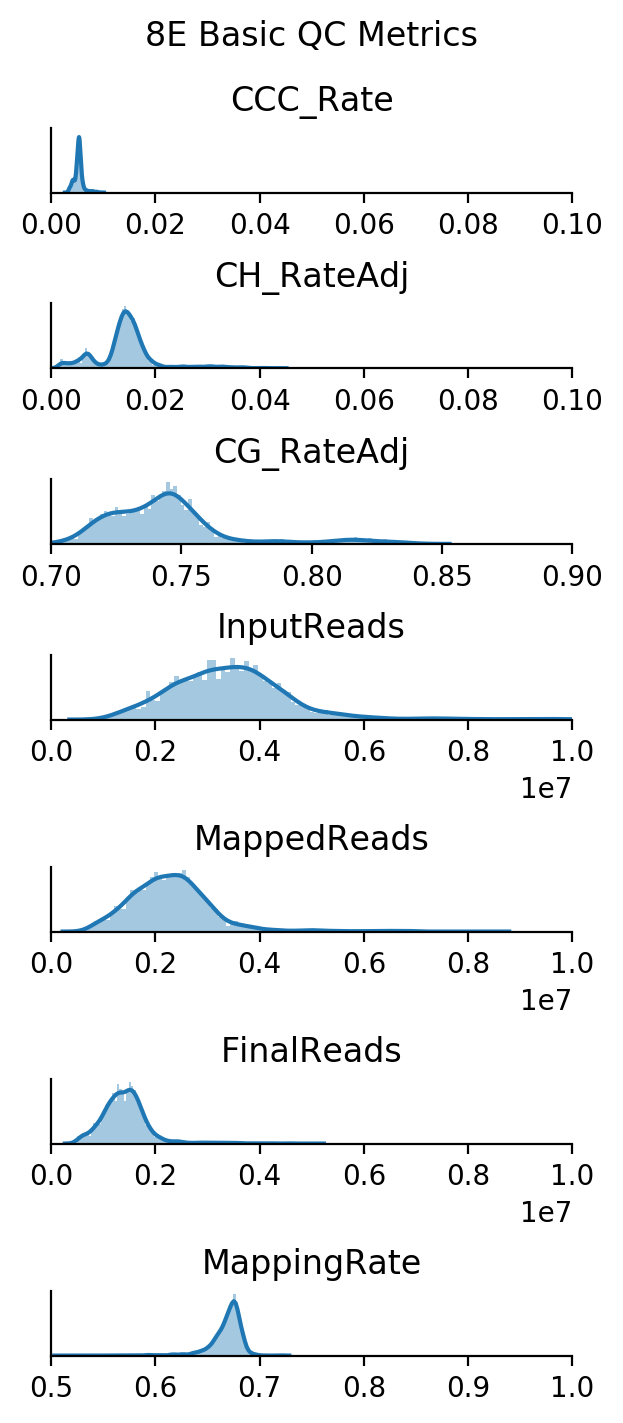

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

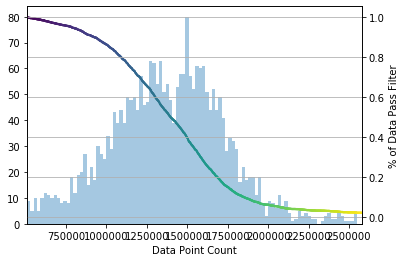

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2585/2585 (100.0%)
CG_RateAdj passed 2585/2585 (100.0%)
CH_RateAdj passed 2585/2585 (100.0%)
FinalReads passed 2585/2585 (100.0%)
MappingRate passed 2585/2585 (100.0%)
Overall passed 2585/2585 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
190711 1309
190716 1276


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 309 80.5%
ad002 332 86.5%
ad004 318 82.8%
ad006 327 85.2%
ad007 327 85.2%
ad008 330 85.9%
ad010 320 83.3%
ad012 322 83.9%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
8E_M_10,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...,0.005505,0.744279,0.742863,0.020649,0.015228,2714916.0,6036476,4014048.0,8E,...,-9.240629,-8.918925,11.856467,6.675551,CA3 Cadm2,1.875794,-6.347604,-3.445744,-4.133640,True
8E_M_100,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...,0.004702,0.723100,0.721792,0.012400,0.007735,3302547.0,7683706,5370970.0,8E,...,-2.971807,-17.519747,-7.295388,-39.588654,CA1 Outlier,7.613317,-1.704495,-6.343327,29.652083,True
8E_M_1000,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.005423,0.739960,0.738542,0.021733,0.016399,1369094.0,3658050,2381916.0,8E,...,-11.314914,-3.215770,20.089499,22.070504,CA3 Cadm2,-0.014122,-4.915470,-8.985813,1.292490,True
8E_M_1002,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.004117,0.745511,0.744459,0.010192,0.006101,4571390.0,11822434,8079217.0,8E,...,-2.397597,-9.806877,0.913349,22.133438,ODC odc-large,-1.228680,2.493599,6.034119,7.812877,True
8E_M_1003,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.005528,0.750461,0.749074,0.023083,0.017652,1334845.0,3479288,2337068.0,8E,...,-9.918164,-7.047932,33.696385,11.054335,CA3 Cadm2,6.591190,-8.556833,14.142539,-13.054063,True
8E_M_1004,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.005139,0.720911,0.719470,0.018680,0.013611,1513297.0,3992238,2696232.0,8E,...,-2.576880,-22.856524,-27.778642,-19.532871,CA1 Chrm3,4.265229,-7.813814,-27.147599,-1.739304,True
8E_M_1005,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.005460,0.746288,0.744895,0.021508,0.016137,1633937.0,4338772,2909268.0,8E,...,-11.804232,-3.360025,20.097448,22.812399,CA3 Cadm2,-0.459262,-5.832338,-11.241286,0.556307,True
8E_M_1006,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.005506,0.743908,0.742490,0.021339,0.015920,1709449.0,4506672,3013013.0,8E,...,-11.929652,-2.756029,16.479164,24.738815,CA3 Cadm2,-1.113081,-4.528910,-12.583492,4.763468,True
8E_M_1007,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.003686,0.737566,0.736596,0.008413,0.004745,3037080.0,8076670,5479219.0,8E,...,-4.001135,-9.899041,-0.776981,20.887025,ODC odc-large,-5.614555,5.834504,-0.496875,24.751177,True
8E_M_1008,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.005026,0.727382,0.726005,0.018815,0.013859,1333597.0,3619216,2377637.0,8E,...,-1.279223,-22.729719,-32.136664,-23.670634,CA1 Chrm3,3.946476,-6.272434,-31.695174,1.344263,True
